In [9]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import numpy as np
import joblib

In [2]:
# Directory containing your files
data_dir = r'D:\ZAKRIA\Client_2\train\train'

# Initialize empty lists to hold data and label DataFrames
data_files = []
label_files = []

# Populate the lists with file paths
for file_name in os.listdir(data_dir):
    if "data" in file_name:
        data_files.append(os.path.join(data_dir, file_name))
    elif "events" in file_name:
        label_files.append(os.path.join(data_dir, file_name))


In [3]:
print(data_files)
print(label_files)

['D:\\ZAKRIA\\Client_2\\train\\train\\subj10_series1_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj10_series2_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj10_series3_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj10_series4_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj10_series5_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj10_series6_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj10_series7_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj10_series8_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj11_series1_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj11_series2_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj11_series3_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj11_series4_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj11_series5_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj11_series6_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj11_series7_data.csv', 'D:\\ZAKRIA\\Client_2\\train\\train\\subj11_series8_da

In [4]:
data_frames = [pd.read_csv(file) for file in tqdm(data_files, desc="Reading data files")]
data_df = pd.concat(data_frames, ignore_index=True)

label_frames = [pd.read_csv(file) for file in tqdm(label_files, desc="Reading labels files")]
label_df = pd.concat(label_frames, ignore_index=True)


Reading labels files: 100%|██████████| 96/96 [00:21<00:00,  4.50it/s]


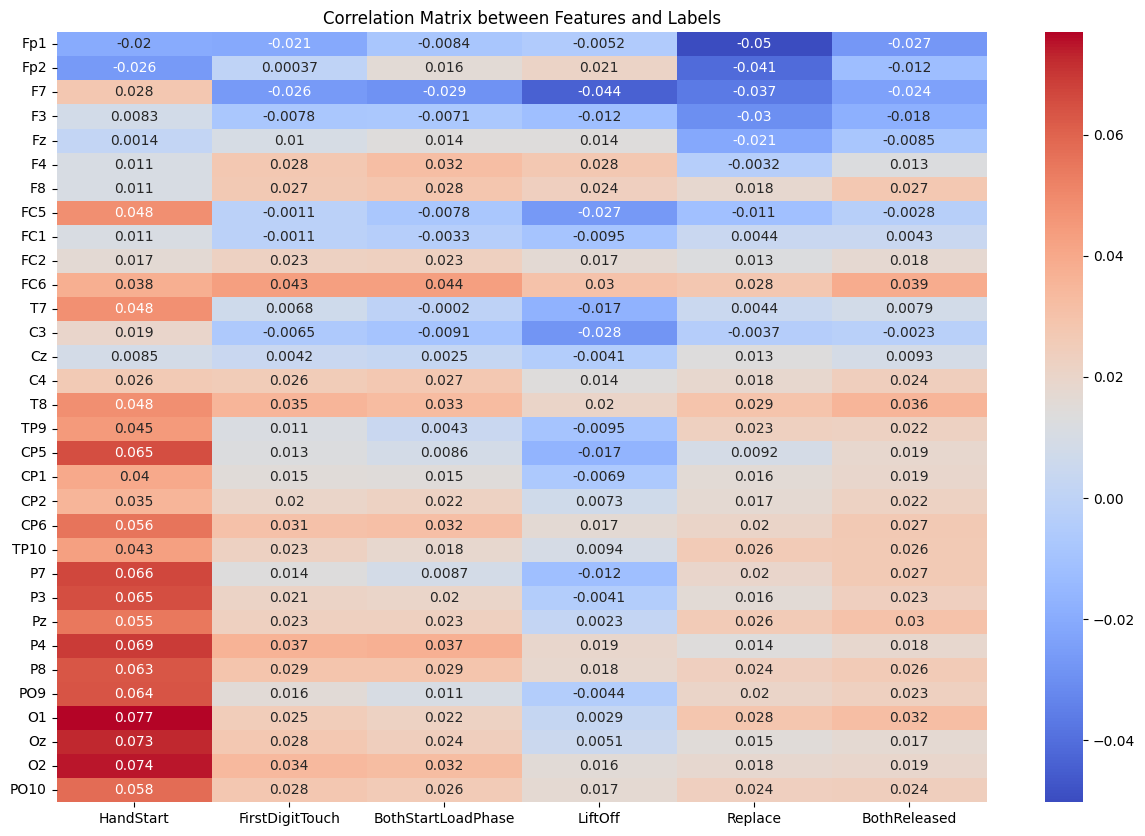

In [6]:
# Merge data and labels on the 'id' column
merged_df = pd.merge(data_df, label_df, on="id")

# Dropping the 'id' column for correlation analysis
corr_data = merged_df.drop(columns=["id"])

# Calculating the correlation between features and labels
corr_matrix = corr_data.corr().loc[data_df.columns[1:], label_df.columns[1:]]

# Plotting the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix between Features and Labels")
plt.show()

In [5]:
#   ENTERIES IN THE DATA
print(f"Number of lines in the loaded training data file: {data_df.shape[0]}")
print(f"Number of lines in the loaded labels file: {label_df.shape[0]}")


Number of lines in the loaded training data file: 17985754
Number of lines in the loaded labels file: 17985754


In [9]:
# Save the data
corr_matrix.to_csv('correlation_matrix.csv')

In [9]:
print(corr_matrix)

      HandStart  FirstDigitTouch  BothStartLoadPhase   LiftOff   Replace  \
Fp1   -0.020017        -0.020776           -0.008406 -0.005192 -0.050249   
Fp2   -0.026393         0.000373            0.016196  0.021049 -0.041112   
F7     0.027870        -0.026179           -0.029050 -0.043929 -0.036815   
F3     0.008313        -0.007828           -0.007109 -0.011864 -0.030088   
Fz     0.001411         0.010339            0.014105  0.013864 -0.021262   
F4     0.010703         0.027525            0.031719  0.027645 -0.003187   
F8     0.010645         0.027205            0.028351  0.023595  0.018287   
FC5    0.048290        -0.001124           -0.007838 -0.026845 -0.011087   
FC1    0.011131        -0.001119           -0.003309 -0.009474  0.004361   
FC2    0.016599         0.022541            0.022940  0.016788  0.012791   
FC6    0.037907         0.043372            0.043556  0.029831  0.028145   
T7     0.047714         0.006781           -0.000200 -0.017035  0.004423   
C3     0.019

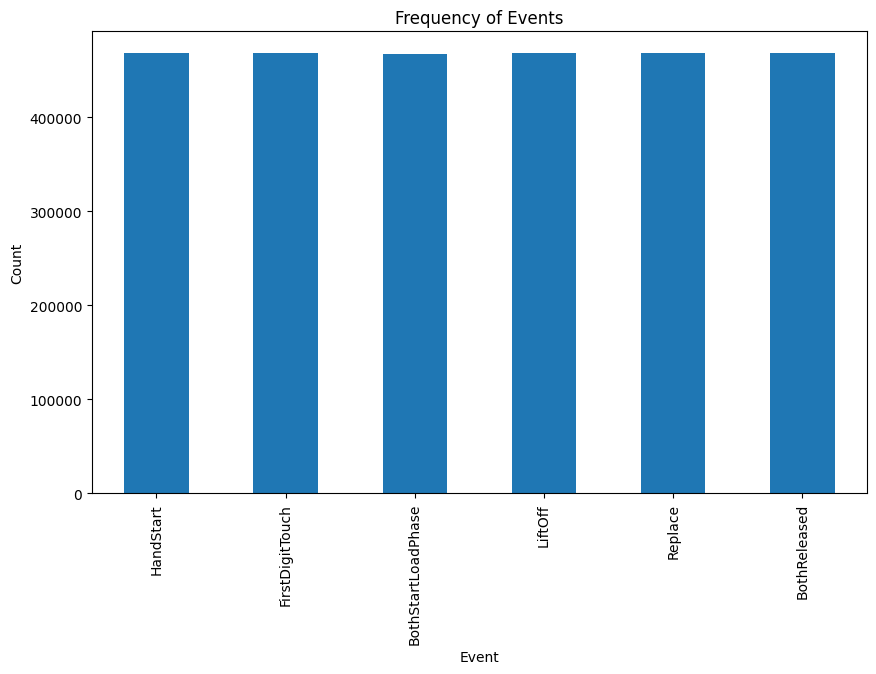

HandStart             468000
FirstDigitTouch       468000
BothStartLoadPhase    467330
LiftOff               468000
Replace               468000
BothReleased          468000
dtype: int64


In [7]:
# Frequency graphs of events (labels)
label_columns = label_df.columns[1:]
label_sums = label_df[label_columns].sum()

plt.figure(figsize=(10, 6))
label_sums.plot(kind='bar')
plt.title("Frequency of Events")
plt.xlabel("Event")
plt.ylabel("Count")
plt.show()

print(label_sums)

In [5]:
# Feature Engineering: Selecting the most correlated features
selected_features = [
    'FC6', 'T8', 'CP6', 'P4', 'O2', 'PO10', 'C4', 'P8']

# Merge data and labels on the 'id' column
merged_df = pd.merge(data_df, label_df, on="id")

# Free up memory by deleting the original data and label DataFrames
del data_df
del label_df

# Creating moving averages for selected features
window_size = 5
for feature in selected_features:
    merged_df[f'{feature}_ma'] = merged_df[feature].rolling(window=window_size).mean()

In [6]:
# Dropping rows with NaN values introduced by moving averages
merged_df.dropna(inplace=True)

# Selecting the three most predictable events
selected_events = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase']

# Splitting the data into features and labels
X = merged_df[[f'{feature}_ma' for feature in selected_features]]
y = merged_df[selected_events]

del merged_df

In [8]:
# Splitting the data into training and validation sets (90-10 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

# Model Selection: RandomForest, GradientBoosting, and SVM
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)  # SVM with probability enabled
}


Training RandomForest...


Training RandomForest: 100%|██████████| 1/1 [4:23:27<00:00, 15807.41s/model]


RandomForest model saved as RandomForest_model.pkl
Evaluation for RandomForest:

Event: HandStart
Accuracy: 97.75%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    875724
           1       0.99      0.14      0.25     23564

    accuracy                           0.98    899288
   macro avg       0.98      0.57      0.62    899288
weighted avg       0.98      0.98      0.97    899288



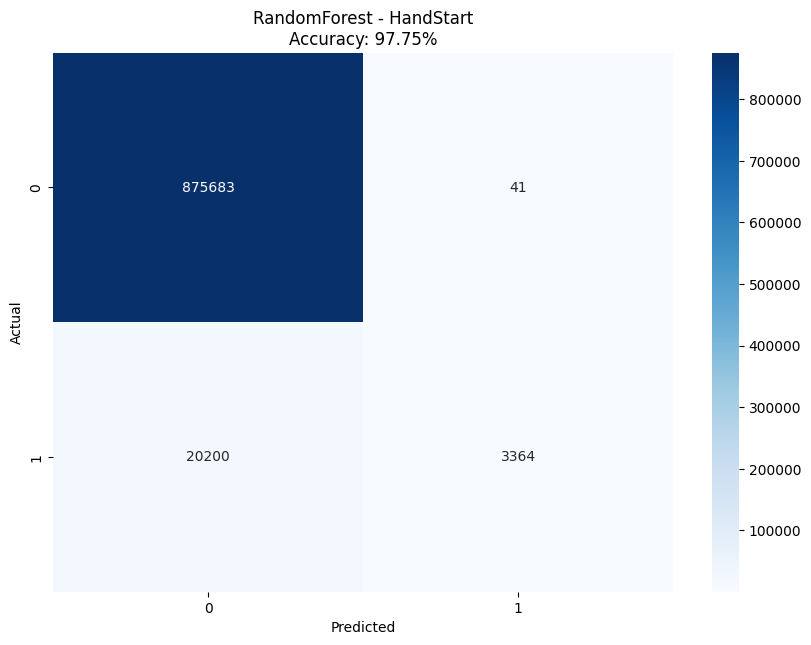


Event: FirstDigitTouch
Accuracy: 97.70%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    875799
           1       0.99      0.12      0.21     23489

    accuracy                           0.98    899288
   macro avg       0.98      0.56      0.60    899288
weighted avg       0.98      0.98      0.97    899288



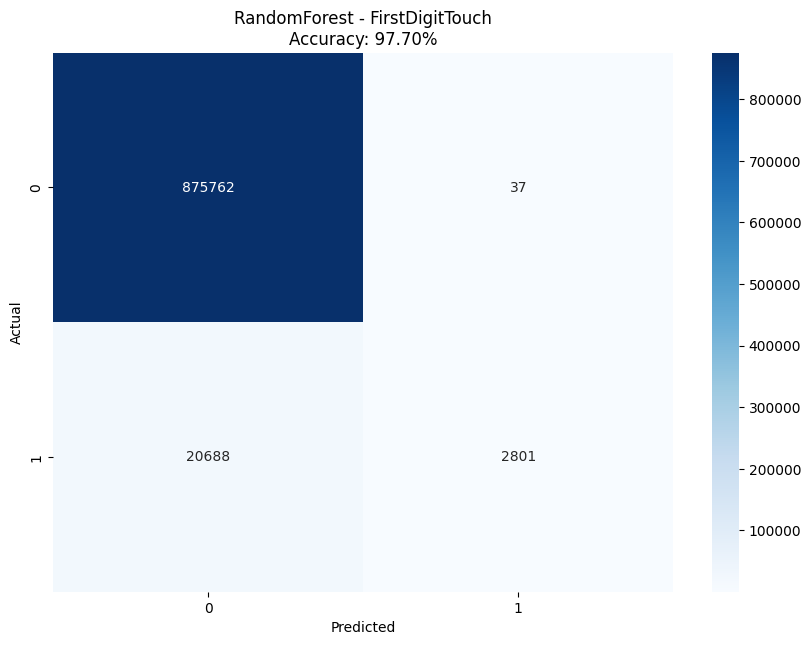


Event: BothStartLoadPhase
Accuracy: 97.70%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    875826
           1       0.98      0.12      0.21     23462

    accuracy                           0.98    899288
   macro avg       0.98      0.56      0.60    899288
weighted avg       0.98      0.98      0.97    899288



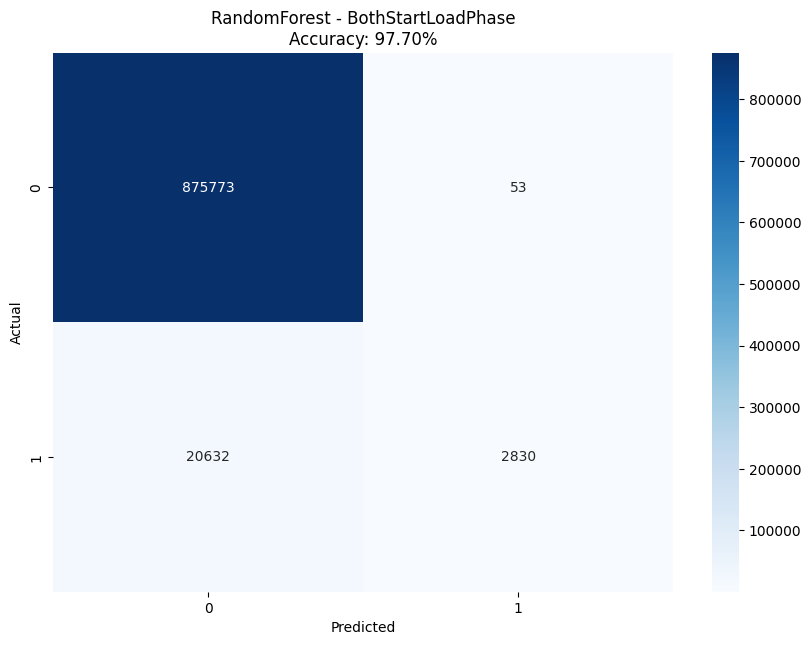

Training GradientBoosting...


Training GradientBoosting:   0%|          | 0/1 [00:14<?, ?model/s]


ValueError: y should be a 1d array, got an array of shape (17086462, 3) instead.

In [10]:
# Training and evaluating the models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Training the model with progress bar
    with tqdm(total=1, desc=f"Training {model_name}", unit="model") as pbar:
        model.fit(X_train, y_train)
        pbar.update(1)
    
    # Save the trained model
    model_filename = f"{model_name}_model.pkl"
    joblib.dump(model, model_filename)
    print(f"{model_name} model saved as {model_filename}")
    
    # Predictions
    y_pred = model.predict(X_val)
    
    # Evaluation
    print(f"Evaluation for {model_name}:")
    for i, event in enumerate(selected_events):
        print(f"\nEvent: {event}")
        acc = accuracy_score(y_val.iloc[:, i], y_pred[:, i])
        print(f"Accuracy: {acc:.2%}")
        print(classification_report(y_val.iloc[:, i], y_pred[:, i]))
        cm = confusion_matrix(y_val.iloc[:, i], y_pred[:, i])
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{model_name} - {event}\nAccuracy: {acc:.2%}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


In [ ]:

# Free up memory
del X
del y
del X_train
del X_val
del y_train
del y_val